# 2D Feature extraction

We start investigating the significance of features extracted from the anonymized video since the 3D model has problems when the target becomes too small (far from camera).
In this approach, we only focus on 2D keypoints extracted from the video as (x,y) coordinates.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
activity = 'S1_A'

try:
    keypoints_2d = np.load(f'keypoints/{activity}_2d.npz', allow_pickle=True)
except Exception as e:
    print(f'Error loading keypoints: {str(e)}')

# Extract the 2D coordinates of all the keypoints in video frames
keypoints_2d = keypoints_2d['positions_2d'].item()[f'{activity}.mp4']['custom'][0]

[frames, joints, num_coordinates] = keypoints_2d.shape

2D keypoints are arranged in a tensor with shape (2398, 17, 2).
- 2398 = number of video frames
-   17 = number of joints identified by 3DVideoPose
-    2 = (x,y) coordinates, the origin (0,0) is the top left corner

In [8]:
# Print the (x,y) coordinate of a single node (joint)
print_coords = lambda node, v : print(f'Joint {node:2d}: <{v[0]:3.2f}, {v[1]:3.2f}>')

node = 8
print_coords(node, keypoints_2d[0,node,:])

Joint  8: <641.56, 275.80>


This is the layout of the joints (the points form a skeleton with head, arms, and legs facing the camera):

<div>
<img src="./images/2d_skeleton.png" height="200px" />
</div>

The code below has been used to reconstruct the mapping and understand how the joints are organised in the data structure.

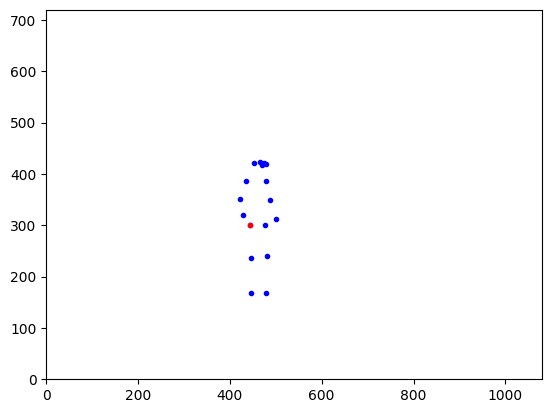

In [9]:
[frame_width, frame_height] = [1080, 720]

frame = 440
highlight_node = 12

for node in range(joints):
    joint_x = keypoints_2d[frame, node, 0]
    joint_y = frame_height - keypoints_2d[frame, node, 1]
    plt.plot(joint_x, joint_y, '.b')

# Set frame limits
plt.xlim((0,frame_width))
plt.ylim((0,frame_height))

# Highlight one node
joint_x_highlighted = keypoints_2d[frame, highlight_node, 0]
joint_y_highlighted = frame_height - keypoints_2d[frame, highlight_node, 1]
plt.plot(joint_x_highlighted, joint_y_highlighted, '.r')

Extract **bones** as vectors with the origin in their corresponding parent joints.

In [10]:
keypoints = keypoints_2d
femur_r = keypoints[:,14,:] - keypoints[:,12,:]
femur_l = keypoints[:,13,:] - keypoints[:,11,:]
tibia_r = keypoints[:,16,:] - keypoints[:,14,:]
tibia_l = keypoints[:,15,:] - keypoints[:,13,:]
humerus_r = keypoints[:,8,:] - keypoints[:,6,:]
humerus_l = keypoints[:,7,:] - keypoints[:,5,:]
ulna_r = keypoints[:,10,:] - keypoints[:,8,:]
ulna_l = keypoints[:,9,:] - keypoints[:,7,:]

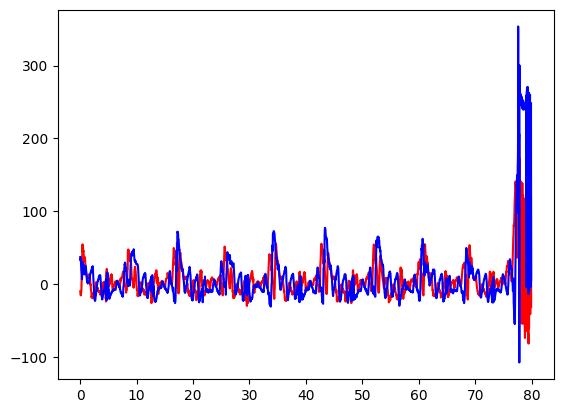

In [11]:
dim = 0
plt.plot(np.linspace(0,len(keypoints)/30,len(keypoints)), femur_r[:,dim], 'r')
plt.plot(np.linspace(0,len(keypoints)/30,len(keypoints)), femur_l[:,dim], 'b')

Extract the feature angle
$\theta = \arctan\left(\frac{y}{x}\right)$

In [12]:
theta = np.rad2deg(np.arctan2(femur_r[:,1], femur_r[:,0]))

## Create the feature vectors

In [30]:
def extract_bones_2d(keypoints):
	# extract target bones from 2D model
	humerus_l = keypoints[:,7,:] - keypoints[:,5,:]
	humerus_r = keypoints[:,8,:] - keypoints[:,6,:]
	ulna_l = keypoints[:,9,:] - keypoints[:,7,:]
	ulna_r = keypoints[:,10,:] - keypoints[:,8,:]
	femur_l = keypoints[:,13,:] - keypoints[:,11,:]
	femur_r = keypoints[:,14,:] - keypoints[:,12,:]
	tibia_l = keypoints[:,15,:] - keypoints[:,13,:]
	tibia_r = keypoints[:,16,:] - keypoints[:,14,:]
    
	return [humerus_l, humerus_r, ulna_l, ulna_r, femur_l, femur_r, tibia_l, tibia_r]


def extract_angles(bones):
    num_frames = bones[0].shape[0]  # number of video frames
    num_bones  = len(bones)         # number of bones

    # prepare a 2D features matrix (videoframes x features)
    angles = np.zeros((num_frames, num_bones))

    # Compute the theta and phi angles for all the video frames (axis=0) and all bones (axis=1)
    for index, bone in enumerate(bones):
        theta = np.rad2deg(np.arctan2(bone[:,1], bone[:,0]))

        angles[:, index] = theta

    return angles

In [32]:
all_activities = [
	"S1_A", "S1_B", "S1_C", "S1_G", "S1_H", "S1_J", "S1_K",
]

for activity in all_activities:
	try:
		keypoints_2d = np.load(f'keypoints/{activity}_2d.npz', allow_pickle=True)
	except Exception as e:
		print(f'Error loading keypoints: {str(e)}')

	# Extract the 2D coordinates of all the keypoints in video frames
	keypoints_2d = keypoints_2d['positions_2d'].item()[f'{activity}.mp4']['custom'][0]

	bones = extract_bones_2d(keypoints_2d)
	angles = extract_angles(bones)

	np.save(f"data/features2d_{activity}.npy", angles)

# Evaluation of a Decision Tree

In [2]:
import sklearn.tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [34]:
time_window = 90
num_features = 8
X = np.empty((0, num_features * 2))
Y = np.empty(0)

for idx, activity in enumerate(all_activities):
  features = np.load(f'data/features2d_{activity}.npy')
  feature_images = np.empty((0, time_window, num_features))

  # Create time sequences of feature vectors
  for line in range(features.shape[0] - time_window):
    feature_over_time = np.expand_dims(features[line:(line+time_window), ...], axis=0)
    feature_images = np.concatenate((feature_images, feature_over_time))

  labels = idx * np.ones((feature_images.shape[0]))

  # Extract mean and variance of each angle in every 'frame', then concatenate in a single vector
  mean = np.mean(feature_images, axis=1)
  std = np.std(feature_images, axis=1)
  values = np.concatenate((mean,std), axis=1)

  X = np.concatenate((X, values))
  Y = np.concatenate((Y, labels))

In [36]:
Xtrain = np.empty((0, num_features * 2))
Xtest = np.empty((0, num_features * 2))
Ytrain = np.empty(0)
Ytest = np.empty(0)

N = 1800

for idx, activity_name in enumerate(all_activities):
    Xtrain = np.concatenate((Xtrain, X[Y==idx][:N, ...]))
    Xtest = np.concatenate((Xtest, X[Y==idx][N+90:, ...]))
    Ytrain = np.concatenate((Ytrain, Y[Y==idx][:N]))
    Ytest = np.concatenate((Ytest, Y[Y==idx][N+90:]))

In [8]:
# Parameters TO TUNE
loss = "log_loss"
max_leaves = 7

In [37]:
clf = sklearn.tree.DecisionTreeClassifier(criterion=loss, max_leaf_nodes=max_leaves)
clf.fit(Xtrain, Ytrain)

DecisionTreeClassifier(criterion='log_loss', max_leaf_nodes=7)

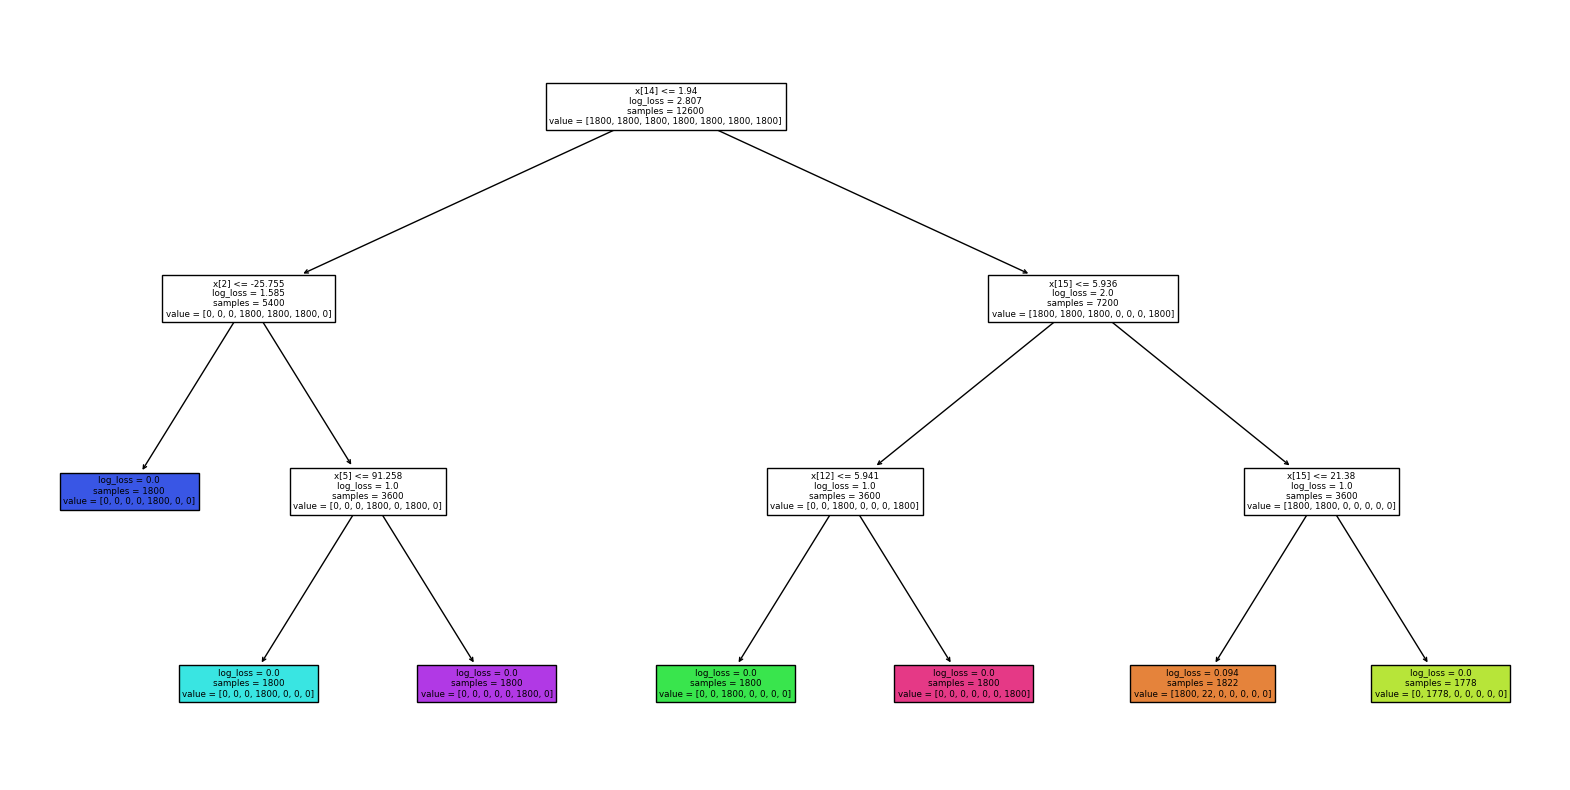

In [38]:
plt.figure(figsize=(20,10))
sklearn.tree.plot_tree(clf, filled=True)
plt.show()

In [39]:
predicted = clf.predict(Xtest)

In [40]:
report = classification_report(Ytest, predicted)
cm = confusion_matrix(Ytest, predicted)

In [41]:
print(report)

              precision    recall  f1-score   support

         0.0       0.92      0.84      0.88       418
         1.0       0.85      0.93      0.89       418
         2.0       0.90      1.00      0.95       418
         3.0       1.00      0.77      0.87       420
         4.0       1.00      1.00      1.00       420
         5.0       0.89      1.00      0.94       418
         6.0       1.00      1.00      1.00       420

    accuracy                           0.93      2932
   macro avg       0.94      0.93      0.93      2932
weighted avg       0.94      0.93      0.93      2932



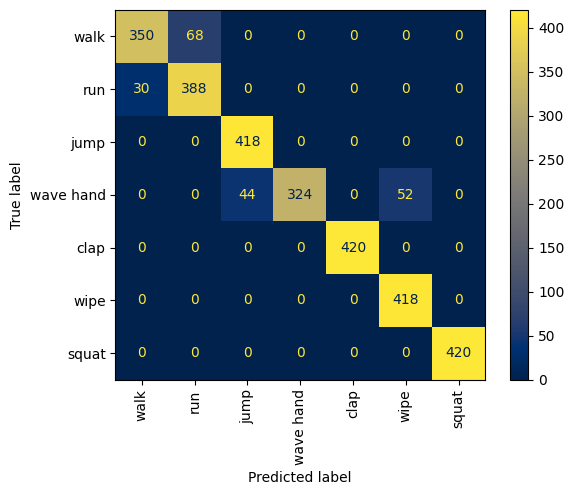

In [42]:
semantic_classes = ['walk', 'run', 'jump', 'wave hand', 'clap', 'wipe', 'squat']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=semantic_classes)
plot = disp.plot(cmap='cividis', xticks_rotation='vertical')